In [ ]:
import numpy as np

# Load the data from the file
data = np.load('psths.npz')
X = data['X']     # 3D array with dimensions N x C x T
times = data['times']  # 1D array with time points

### 1. Plot raw PSTHs

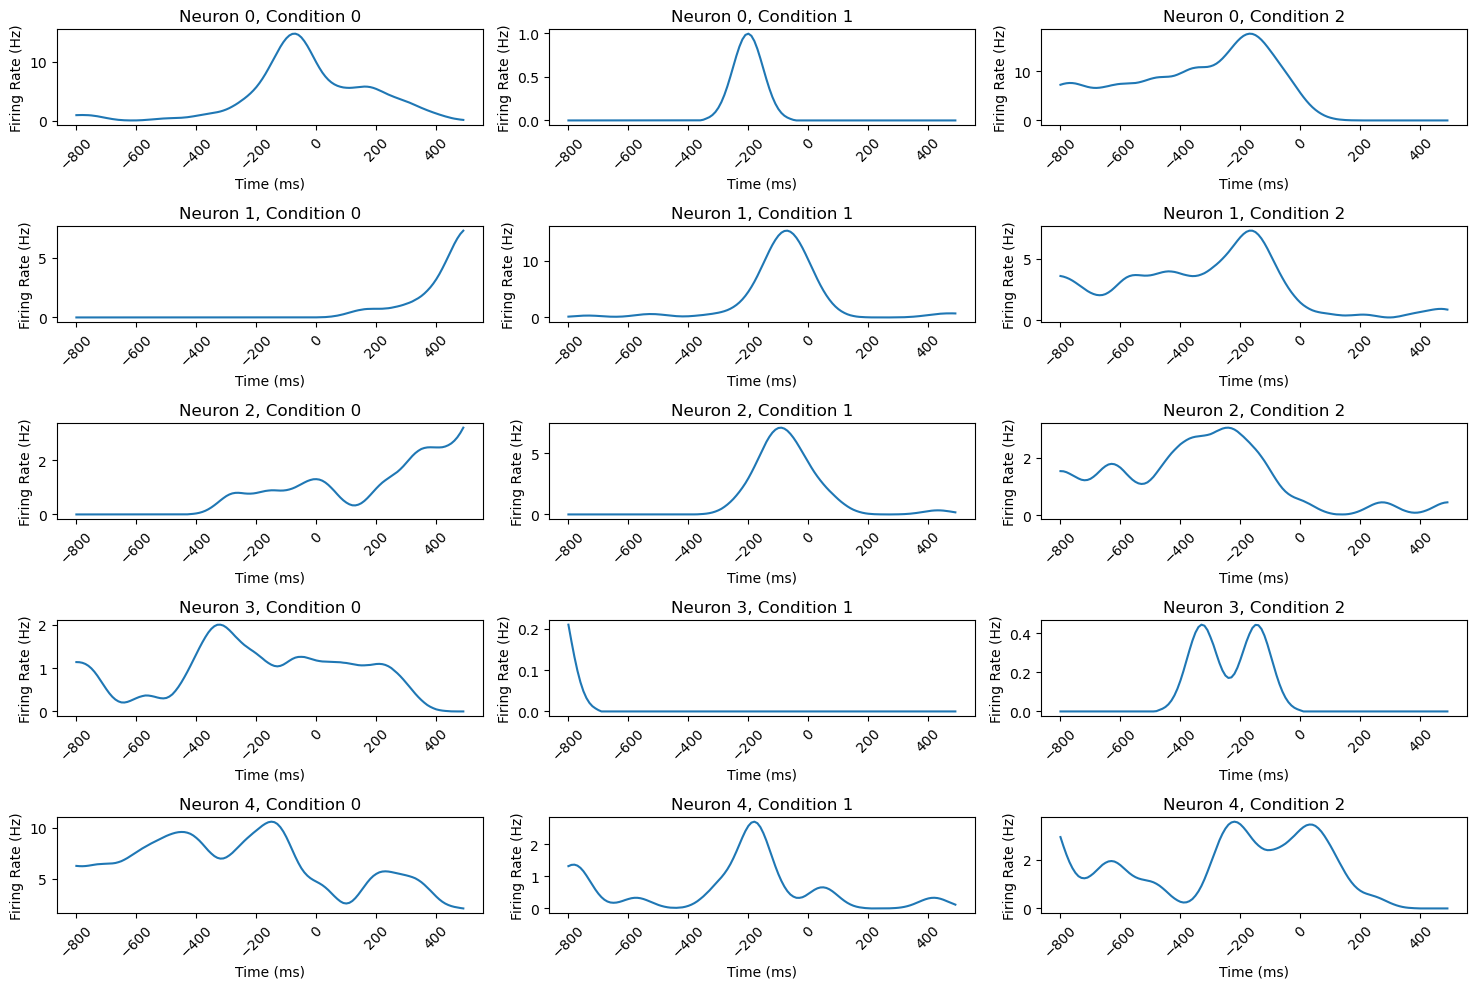

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sample_neurons = [0, 1, 2, 3, 4]  # Indices of representative neurons
sample_conditions = [0, 1, 2]     # Indices of a few conditions

# Plotting PSTHs for the selected neurons and conditions
plt.figure(figsize=(15, 10))

for i, neuron in enumerate(sample_neurons):
    for j, condition in enumerate(sample_conditions):
        plt.subplot(len(sample_neurons), len(sample_conditions), i * len(sample_conditions) + j + 1)
        plt.plot(times, X[neuron, condition, :])
        plt.xlabel("Time (ms)")
        plt.ylabel("Firing Rate (Hz)")
        plt.title(f"Neuron {neuron}, Condition {condition}")
        plt.xticks(rotation=45)
        
plt.tight_layout()
plt.show()

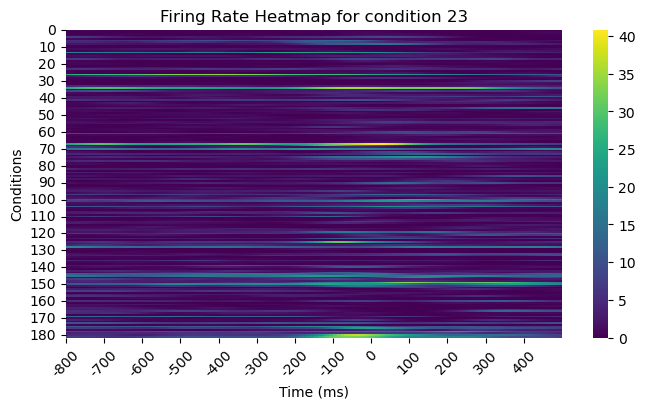

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a condition (e.g., condition 0)
condition = 23
firing_rate = X[:, condition, :] # Shape N x T

plt.figure(figsize=(8, 4))
sns.heatmap(firing_rate, xticklabels=10, yticklabels=10, cmap='viridis')

# Set the X-axis ticks with specific time points for better clarity
plt.xticks(ticks=range(0, len(times), 10), labels=times[::10], rotation=45)
plt.xlabel("Time (ms)")
plt.ylabel("Conditions")
plt.title(f"Firing Rate Heatmap for condition {condition}")
plt.show()

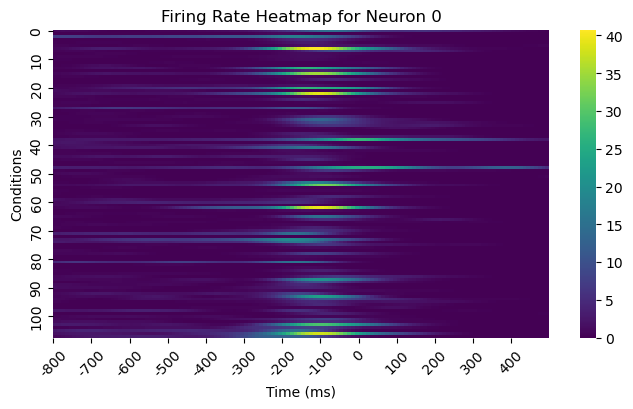

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a neuron (e.g., neuron 0)
neuron = 0
neuron_data = X[neuron, :, :]  # Shape C x T

plt.figure(figsize=(8, 4))
sns.heatmap(neuron_data, xticklabels=10, yticklabels=10, cmap='viridis')

# Set the X-axis ticks with specific time points for better clarity
plt.xticks(ticks=range(0, len(times), 10), labels=times[::10], rotation=45)
plt.xlabel("Time (ms)")
plt.ylabel("Conditions")
plt.title(f"Firing Rate Heatmap for Neuron {neuron}")
plt.show()